In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import einops
import matplotlib.pyplot as plt

In [2]:
@torch.no_grad()
def recombine_outputs(embedding: nn.Embedding, planning_output: torch.Tensor, top_k: int) -> torch.Tensor:
    sorted = torch.sort(planning_output, dim=-1, descending=True)
    sorted_tokens = sorted.indices[:, :top_k]
    print(sorted_tokens.shape)
    embeddings = embedding(sorted_tokens)
    print(embeddings.shape)
    embeddings = torch.sum(embeddings * sorted.values[:, :top_k].unsqueeze(-1), dim=1)
    print(embeddings.shape)
    return embeddings

In [3]:
recombine_outputs(nn.Embedding(10, 10), torch.randn(2, 10), 3).shape

torch.Size([2, 3])
torch.Size([2, 3, 10])
torch.Size([2, 10])


torch.Size([2, 10])

In [4]:
@torch.no_grad()
def recombine_outputs(embedding: nn.Embedding, planning_output: torch.Tensor, top_k: int) -> torch.Tensor:
    planning_output.grad = None
    sorted = torch.sort(planning_output.detach(), dim=-1, descending=True)
    del planning_output
    embeddings = 0
    for i in range(top_k):
        new_embs = embedding(sorted.indices[:, i]) * sorted.values[:, i].unsqueeze(-1)
        embeddings = embeddings + new_embs
    return embeddings

In [10]:
recombine_outputs(nn.Embedding(10, 10), torch.randn(5, 10), 3).shape

torch.Size([5, 10])

In [15]:
@torch.no_grad()
def recombine_outputs_final(embedding: nn.Embedding, planning_output: torch.Tensor, top_k: int) -> torch.Tensor:
    planning_output.grad = None
    values, indices = torch.topk(planning_output, k=top_k, dim=-1)
    normalized_values = values / values.sum(dim=-1, keepdim=True)
    embedded = embedding(indices)  # shape: (batch_size, top_k, embedding_dim)
    weighted = embedded * normalized_values.unsqueeze(-1)  # shape: (batch_size, top_k, embedding_dim)
    result = weighted.sum(dim=1)  # shape: (batch_size, embedding_dim)
    return result

In [18]:
recombine_outputs_final(nn.Embedding(10, 10), torch.randn(5, 10), 3).shape

torch.Size([5, 10])

In [17]:
emb = nn.Embedding(10, 10)
x = torch.randn(5, 10)
assert (recombine_outputs(emb, x, 3) - recombine_outputs_final(emb, x, 3)).abs().max() < 1e-6

## Causal mask

In [30]:
max_seq_len = 100
causal_mask = torch.tril(torch.ones(max_seq_len, max_seq_len, dtype=torch.bool))
bias_range = torch.arange(-max_seq_len+1, 1)
position_bias_base = bias_range.unsqueeze(0) - bias_range.unsqueeze(1)
negative_infinity_matrix_base = torch.empty_like(position_bias_base, dtype=torch.bfloat16).fill_(-float("inf"))


class LatentAttentionBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.position_bias_mult = nn.Parameter(torch.tensor(1.))

    def make_mask(self, x, first_planning_token_idx: int | None = None):
        seq_len = x.shape[1]
        attn_mask = torch.where(
            causal_mask[:seq_len, :seq_len], 
            F.softplus(self.position_bias_mult) * position_bias_base[:seq_len, :seq_len], 
            negative_infinity_matrix_base[:seq_len, :seq_len]
        )

        if first_planning_token_idx is not None:
            first_planning_token_idx = None if first_planning_token_idx >= seq_len else first_planning_token_idx

            attn_mask[first_planning_token_idx:, first_planning_token_idx:] = (
                F.softplus(self.position_bias_mult) 
                * position_bias_base[first_planning_token_idx:seq_len, first_planning_token_idx:seq_len]
            )

        return attn_mask

In [32]:
def test_make_mask():
    attn = LatentAttentionBlock()
    x = torch.randn(8, 8)
    print(attn.make_mask(x))
    print(attn.make_mask(x, 3))


test_make_mask()

tensor([[ 0.0000,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-1.3133,  0.0000,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-2.6265, -1.3133,  0.0000,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-3.9398, -2.6265, -1.3133,  0.0000,    -inf,    -inf,    -inf,    -inf],
        [-5.2530, -3.9398, -2.6265, -1.3133,  0.0000,    -inf,    -inf,    -inf],
        [-6.5663, -5.2530, -3.9398, -2.6265, -1.3133,  0.0000,    -inf,    -inf],
        [-7.8796, -6.5663, -5.2530, -3.9398, -2.6265, -1.3133,  0.0000,    -inf],
        [-9.1928, -7.8796, -6.5663, -5.2530, -3.9398, -2.6265, -1.3133,  0.0000]],
       grad_fn=<WhereBackward0>)
tensor([[ 0.0000,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-1.3133,  0.0000,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-2.6265, -1.3133,  0.0000,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-3.9398, -2.6265, -1.3133,  0.0000,  1.3133,  2.6265,  

## Randomize masking rate

In [18]:
def randomize_masking_rate(mean: float, concentration: int = 5) -> float:
    alpha = mean * concentration
    beta = (1 - mean) * concentration
    return torch.distributions.Beta(alpha, beta).sample()

In [22]:
def make_distr(mean: float, concentration: int, n: int) -> torch.Tensor:
    return torch.tensor([randomize_masking_rate(mean, concentration).item() for _ in range(n)])


def plot_distr(distr: torch.Tensor):
    plt.hist(distr.numpy(), bins=100)
    plt.show()

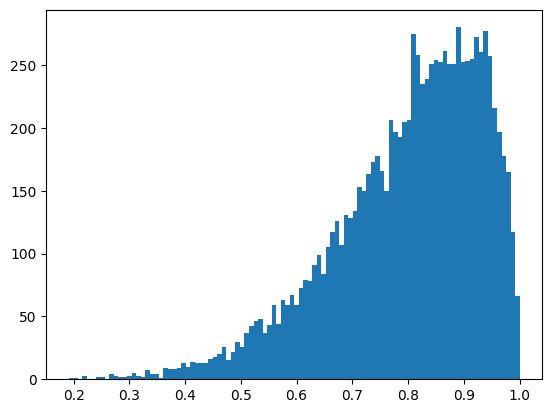

In [29]:
mean = 0.8
concentration = 8
plot_distr(make_distr(mean, concentration, 10_000))